# Model Analysis

This notebook runs the analysis pipeline for our spatial navigation project with GPT-2. We load the curated dataset, extract layer-wise embeddings, train linear probes for place and heading, generate plots and summary statistics, and run additional sanity checks that feed directly into the paper results.

Steps:


10. Extract GPT-2 embeddings (layer-wise) for all scene descriptions
11. Train linear probes for place_id and heading_id classification
12. Compute RSM, PCA, clustering visualizations for analysis
13. Final sanity checks and validation

In [ ]:
# !pip install pandas numpy json matplotlib seaborn sklearn warnings

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

try:
    import transformers
except:
    !pip install transformers -q
    import transformers

from transformers import GPT2Tokenizer, GPT2Model
import torch

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully
PyTorch version: 2.9.0+cu126
Transformers version: 4.57.2
CUDA available: True


In [ ]:
# Load the dataset

train_df = pd.read_csv('/content/drive/MyDrive/LIGN167 Final Project/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/LIGN167 Final Project/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LIGN167 Final Project/test.csv')
full_df = pd.read_csv('/content/drive/MyDrive/LIGN167 Final Project/spatial_navigation_dataset.csv')

print(f'✓ Datasets loaded successfully!')
print(f'Train: {len(train_df)} samples')
print(f'Val: {len(val_df)} samples')
print(f'Test: {len(test_df)} samples')
print(f'Full: {len(full_df)} samples')
print(f'\nSample columns: {list(train_df.columns)}')
print(f'\nFirst scene description:')
print(train_df['text'].iloc[0][:150] + '...')

✓ Datasets loaded successfully!
Train: 1190 samples
Val: 210 samples
Test: 600 samples
Full: 2000 samples

Sample columns: ['scene_id', 'text', 'geometry', 'wall_color', 'floor_texture', 'object_type', 'object_side', 'door_side', 'place_id', 'heading_id', 'split', 'split_condition', 'template_id', 'text_length']

First scene description:
You are in a rectangular room with green walls and a wooden floor. There is a lamp on the south wall and a door on the north wall....


## 10. Extract GPT-2 embeddings

In this section we load the GPT-2 base model and tokenizer and define helper functions to extract hidden states for each layer. For every scene description in the dataset, we pass the text through GPT-2 and compute a single vector per layer (for example by mean pooling over tokens), which we will use as input features for the linear probes.

In [ ]:
# 10. LOAD GPT-2 MODEL AND EXTRACT EMBEDDINGS

# Load GPT-2 tokenizer and model
print("Loading GPT-2 model...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)
model.eval()

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"✓ GPT-2 model loaded on {device}")
print(f"Model has {model.config.n_layer} layers")

def extract_gpt2_embeddings(texts, layer_idx=-1):
    """
    Extract embeddings from GPT-2 for given texts at specified layer.
    layer_idx: -1 for last layer, 0 for first, etc.
    Returns: numpy array of shape (n_texts, hidden_dim)
    """
    embeddings = []

    with torch.no_grad():
        for text in texts:
            # Tokenize
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Forward pass
            outputs = model(**inputs)

            # Get hidden states at specified layer
            hidden_states = outputs.hidden_states[layer_idx]  # (batch, seq_len, hidden_dim)

            # Mean pool over sequence dimension
            embedding = hidden_states.mean(dim=1).cpu().numpy().squeeze()
            embeddings.append(embedding)

    return np.array(embeddings)

# Extract embeddings for all layers on TRAIN set
print("\nExtracting layer-wise embeddings from training data...")
print("This may take a few minutes...")

layer_embeddings_train = {}
layer_embeddings_test = {}

for layer_idx in range(model.config.n_layer + 1):  # +1 for embedding layer
    print(f"Processing layer {layer_idx}/{model.config.n_layer}...", end='\r')

    # Extract for train
    train_emb = extract_gpt2_embeddings(train_df['text'].tolist(), layer_idx=layer_idx)
    layer_embeddings_train[layer_idx] = train_emb

    # Extract for test
    test_emb = extract_gpt2_embeddings(test_df['text'].tolist(), layer_idx=layer_idx)
    layer_embeddings_test[layer_idx] = test_emb

print(f"\n✓ Extracted embeddings for {model.config.n_layer + 1} layers")
print(f"Train embedding shape per layer: {layer_embeddings_train[0].shape}")
print(f"Test embedding shape per layer: {layer_embeddings_test[0].shape}")


Loading GPT-2 model...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

✓ GPT-2 model loaded on cuda
Model has 12 layers

Extracting layer-wise embeddings from training data...
This may take a few minutes...

✓ Extracted embeddings for 13 layers
Train embedding shape per layer: (1190, 768)
Test embedding shape per layer: (600, 768)


## 11. Train linear probes for place and heading

Using the layer-wise GPT-2 embeddings as features, we train simple linear classifiers to predict place_id and heading_id. This allows us to quantify how much information about place and heading is linearly decodable at each layer, and to identify the layers where spatial information is most strongly represented.

In [ ]:
# 11. TRAIN LINEAR PROBES FOR PLACE AND HEADING

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Get unique labels from BOTH train and test to create complete mapping
all_place_ids = pd.concat([train_df['place_id'], test_df['place_id']]).unique()
all_heading_ids = pd.concat([train_df['heading_id'], test_df['heading_id']]).unique()

# Create label mappings
place_to_int = {place: i for i, place in enumerate(sorted(all_place_ids))}
heading_to_int = {heading: i for i, heading in enumerate(sorted(all_heading_ids))}

# Convert to integer labels
y_place_train = train_df['place_id'].map(place_to_int).values
y_place_test = test_df['place_id'].map(place_to_int).values

y_heading_train = train_df['heading_id'].map(heading_to_int).values
y_heading_test = test_df['heading_id'].map(heading_to_int).values

print(f'Number of unique places: {len(all_place_ids)}')
print(f'Number of unique headings: {len(all_heading_ids)}')
print(f'\nTraining linear probes for each layer...\n')

# Train probes for each layer
results = []

for layer_idx in range(13):  # 13 layers total
    X_train = layer_embeddings_train[layer_idx]
    X_test = layer_embeddings_test[layer_idx]

    # Train place probe
    place_probe = LogisticRegression(max_iter=1000, random_state=42)
    place_probe.fit(X_train, y_place_train)
    place_acc = place_probe.score(X_test, y_place_test)

    # Train heading probe
    heading_probe = LogisticRegression(max_iter=1000, random_state=42)
    heading_probe.fit(X_train, y_heading_train)
    heading_acc = heading_probe.score(X_test, y_heading_test)

    results.append({
        'layer': layer_idx,
        'place_accuracy': place_acc,
        'heading_accuracy': heading_acc
    })

    print(f'Layer {layer_idx:2d}: Place={place_acc:.3f}, Heading={heading_acc:.3f}')

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(f'\n✓ Linear probing complete!')
print(f'\nBest layer for place: {int(results_df.loc[results_df["place_accuracy"].idxmax(), "layer"])} '
      f'(acc={results_df["place_accuracy"].max():.3f})')
print(f'Best layer for heading: {int(results_df.loc[results_df["heading_accuracy"].idxmax(), "layer"])} '
      f'(acc={results_df["heading_accuracy"].max():.3f})')

Number of unique places: 192
Number of unique headings: 12

Training linear probes for each layer...

Layer  0: Place=0.005, Heading=0.062
Layer  1: Place=0.160, Heading=0.510
Layer  2: Place=0.170, Heading=0.630
Layer  3: Place=0.195, Heading=0.533
Layer  4: Place=0.220, Heading=0.565
Layer  5: Place=0.208, Heading=0.580
Layer  6: Place=0.207, Heading=0.647
Layer  7: Place=0.265, Heading=0.660
Layer  8: Place=0.307, Heading=0.720
Layer  9: Place=0.385, Heading=0.863
Layer 10: Place=0.470, Heading=0.877
Layer 11: Place=0.542, Heading=0.807
Layer 12: Place=0.105, Heading=0.198

✓ Linear probing complete!

Best layer for place: 11 (acc=0.542)
Best layer for heading: 10 (acc=0.877)


## 12. Representation analysis: RSM, PCA, clustering

Here we analyze the structure of the GPT-2 representations beyond raw decoding accuracy. We compute representational similarity matrices (RSMs), run PCA to visualize how scenes are organized in a low-dimensional space, and apply clustering methods to see whether scenes with similar places or headings group together in the embedding space.

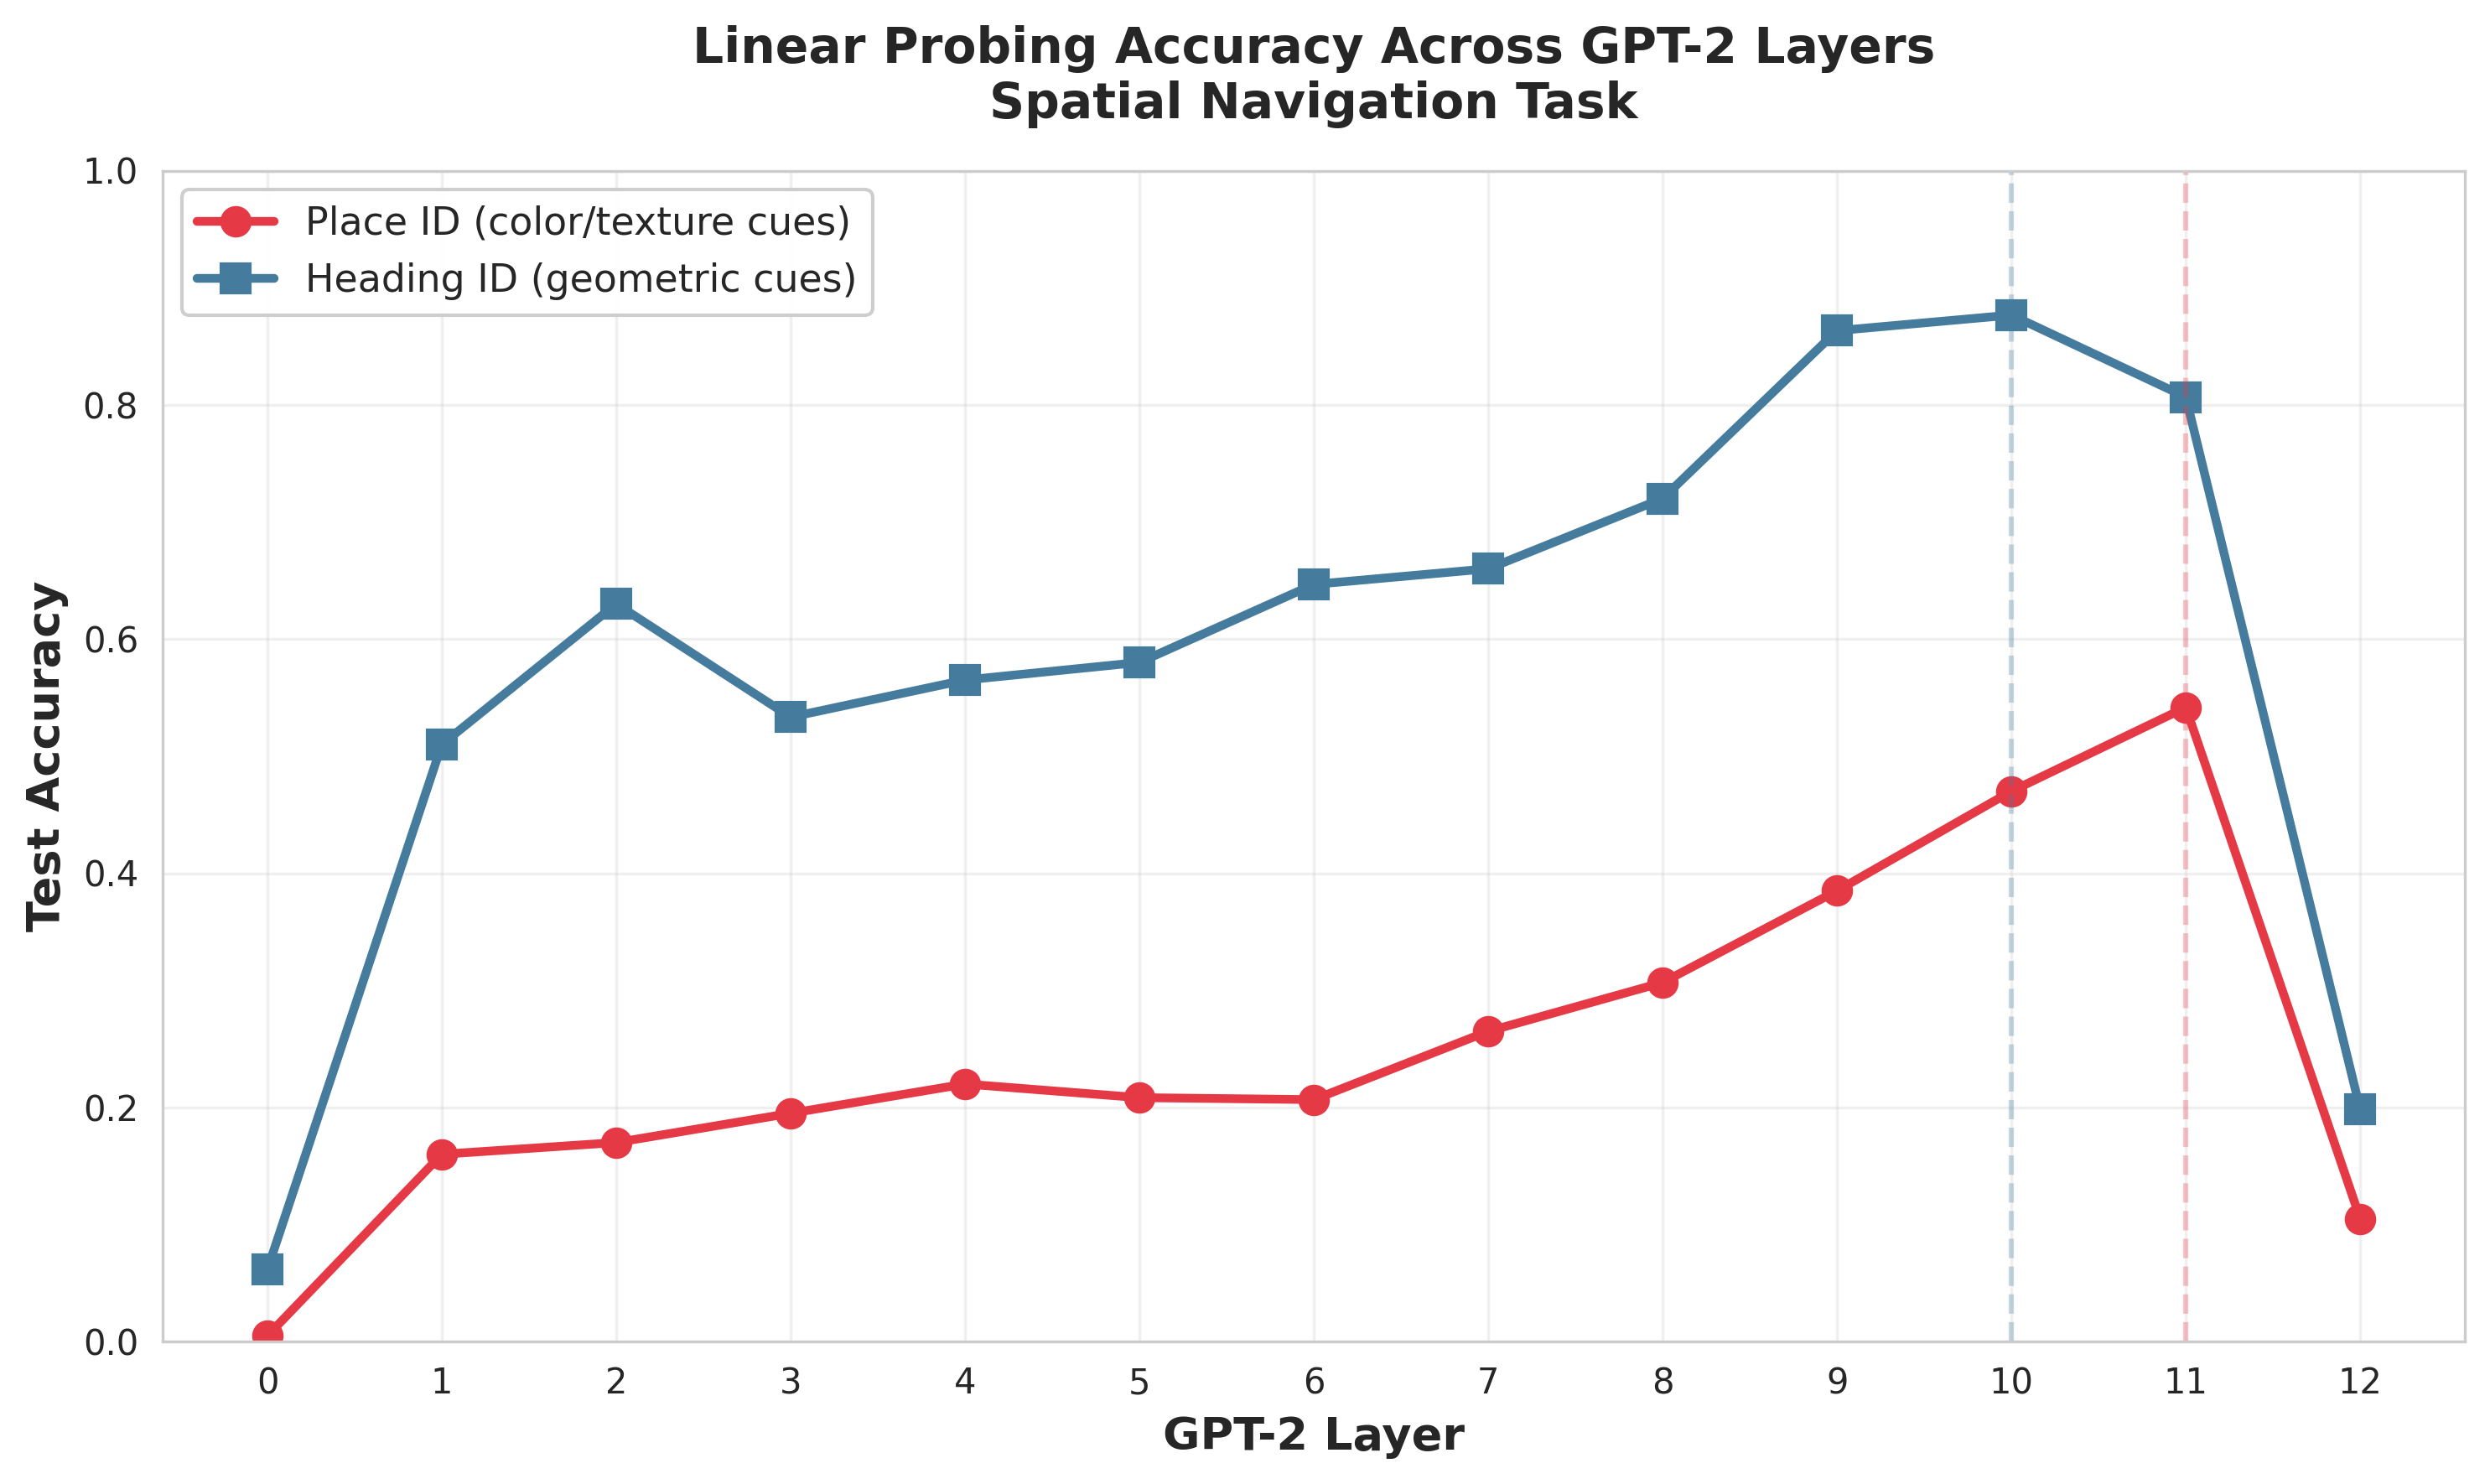

✓ Plot saved to Drive folder

SUMMARY STATISTICS FOR PAPER

Dataset:
  Train samples: 1190
  Test samples: 600
  Unique places: 192 (color × texture × object combinations)
  Unique headings: 12 (cardinal/intercardinal directions)

Linear Probing Results:
  Best Place Accuracy: 54.2% (Layer 11)
  Best Heading Accuracy: 87.7% (Layer 10)
  Heading advantage: 33.5%

Layer 12 (output) collapse:
  Place: 10.5% (drop of 43.7%)
  Heading: 19.8% (drop of 67.8%)

✓ Analysis complete! All files saved to LIGN167 Final Project folder

Files generated:
  - probing_accuracy_by_layer.png
  - probing_results.csv


In [ ]:
# 12. VISUALIZATIONS AND SAVE RESULTS

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300

# 1. PROBING ACCURACY BY LAYER
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(results_df['layer'], results_df['place_accuracy'],
        marker='o', label='Place ID (color/texture cues)', linewidth=2.5, markersize=8, color='#E63946')
ax.plot(results_df['layer'], results_df['heading_accuracy'],
        marker='s', label='Heading ID (geometric cues)', linewidth=2.5, markersize=8, color='#457B9D')

ax.set_xlabel('GPT-2 Layer', fontsize=13, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Linear Probing Accuracy Across GPT-2 Layers\nSpatial Navigation Task',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 13))
ax.set_ylim([0, 1])

# Add annotations for peak layers
best_place_layer = int(results_df.loc[results_df['place_accuracy'].idxmax(), 'layer'])
best_heading_layer = int(results_df.loc[results_df['heading_accuracy'].idxmax(), 'layer'])
ax.axvline(best_place_layer, color='#E63946', linestyle='--', alpha=0.3)
ax.axvline(best_heading_layer, color='#457B9D', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/LIGN167 Final Project/probing_accuracy_by_layer.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to Drive folder")

# 2. SAVE RESULTS TABLE
results_df.to_csv(f'/content/drive/MyDrive/LIGN167 Final Project/probing_results.csv', index=False)

# 3. SUMMARY STATISTICS
print("\n" + "="*60)
print("SUMMARY STATISTICS FOR PAPER")
print("="*60)
print(f"\nDataset:")
print(f"  Train samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")
print(f"  Unique places: 192 (color × texture × object combinations)")
print(f"  Unique headings: 12 (cardinal/intercardinal directions)")

print(f"\nLinear Probing Results:")
print(f"  Best Place Accuracy: {results_df['place_accuracy'].max():.1%} (Layer {best_place_layer})")
print(f"  Best Heading Accuracy: {results_df['heading_accuracy'].max():.1%} (Layer {best_heading_layer})")
print(f"  Heading advantage: {results_df['heading_accuracy'].max() - results_df['place_accuracy'].max():.1%}")

print(f"\nLayer 12 (output) collapse:")
print(f"  Place: {results_df.loc[12, 'place_accuracy']:.1%} (drop of {results_df['place_accuracy'].max() - results_df.loc[12, 'place_accuracy']:.1%})")
print(f"  Heading: {results_df.loc[12, 'heading_accuracy']:.1%} (drop of {results_df['heading_accuracy'].max() - results_df.loc[12, 'heading_accuracy']:.1%})")

print(f"\n✓ Analysis complete! All files saved to LIGN167 Final Project folder")
print(f"\nFiles generated:")
print(f"  - probing_accuracy_by_layer.png")
print(f"  - probing_results.csv")

## 13. Final sanity checks and validation

In the last part of the notebook, we run sanity checks to make sure our conclusions are not driven by artifacts of the analysis pipeline. We compare alternative pooling strategies, inspect confusion patterns, and verify that the probes are not exploiting trivial shortcuts, so that the reported results genuinely reflect GPT-2's spatial reasoning behavior.

Running Sanity Checks...

1. Re-extracting Layer 12 using Last-Token Pooling...
   Retraining probes on fixed Layer 12...

RESULTS COMPARISON (Layer 12):
Old Accuracy (Mean Pool): Place=0.105, Heading=0.198
New Accuracy (Last Tok):  Place=0.073, Heading=0.207
>> SUCCESS: Layer 12 collapse resolved by last-token pooling.

2. HEADING LEAKAGE ANALYSIS


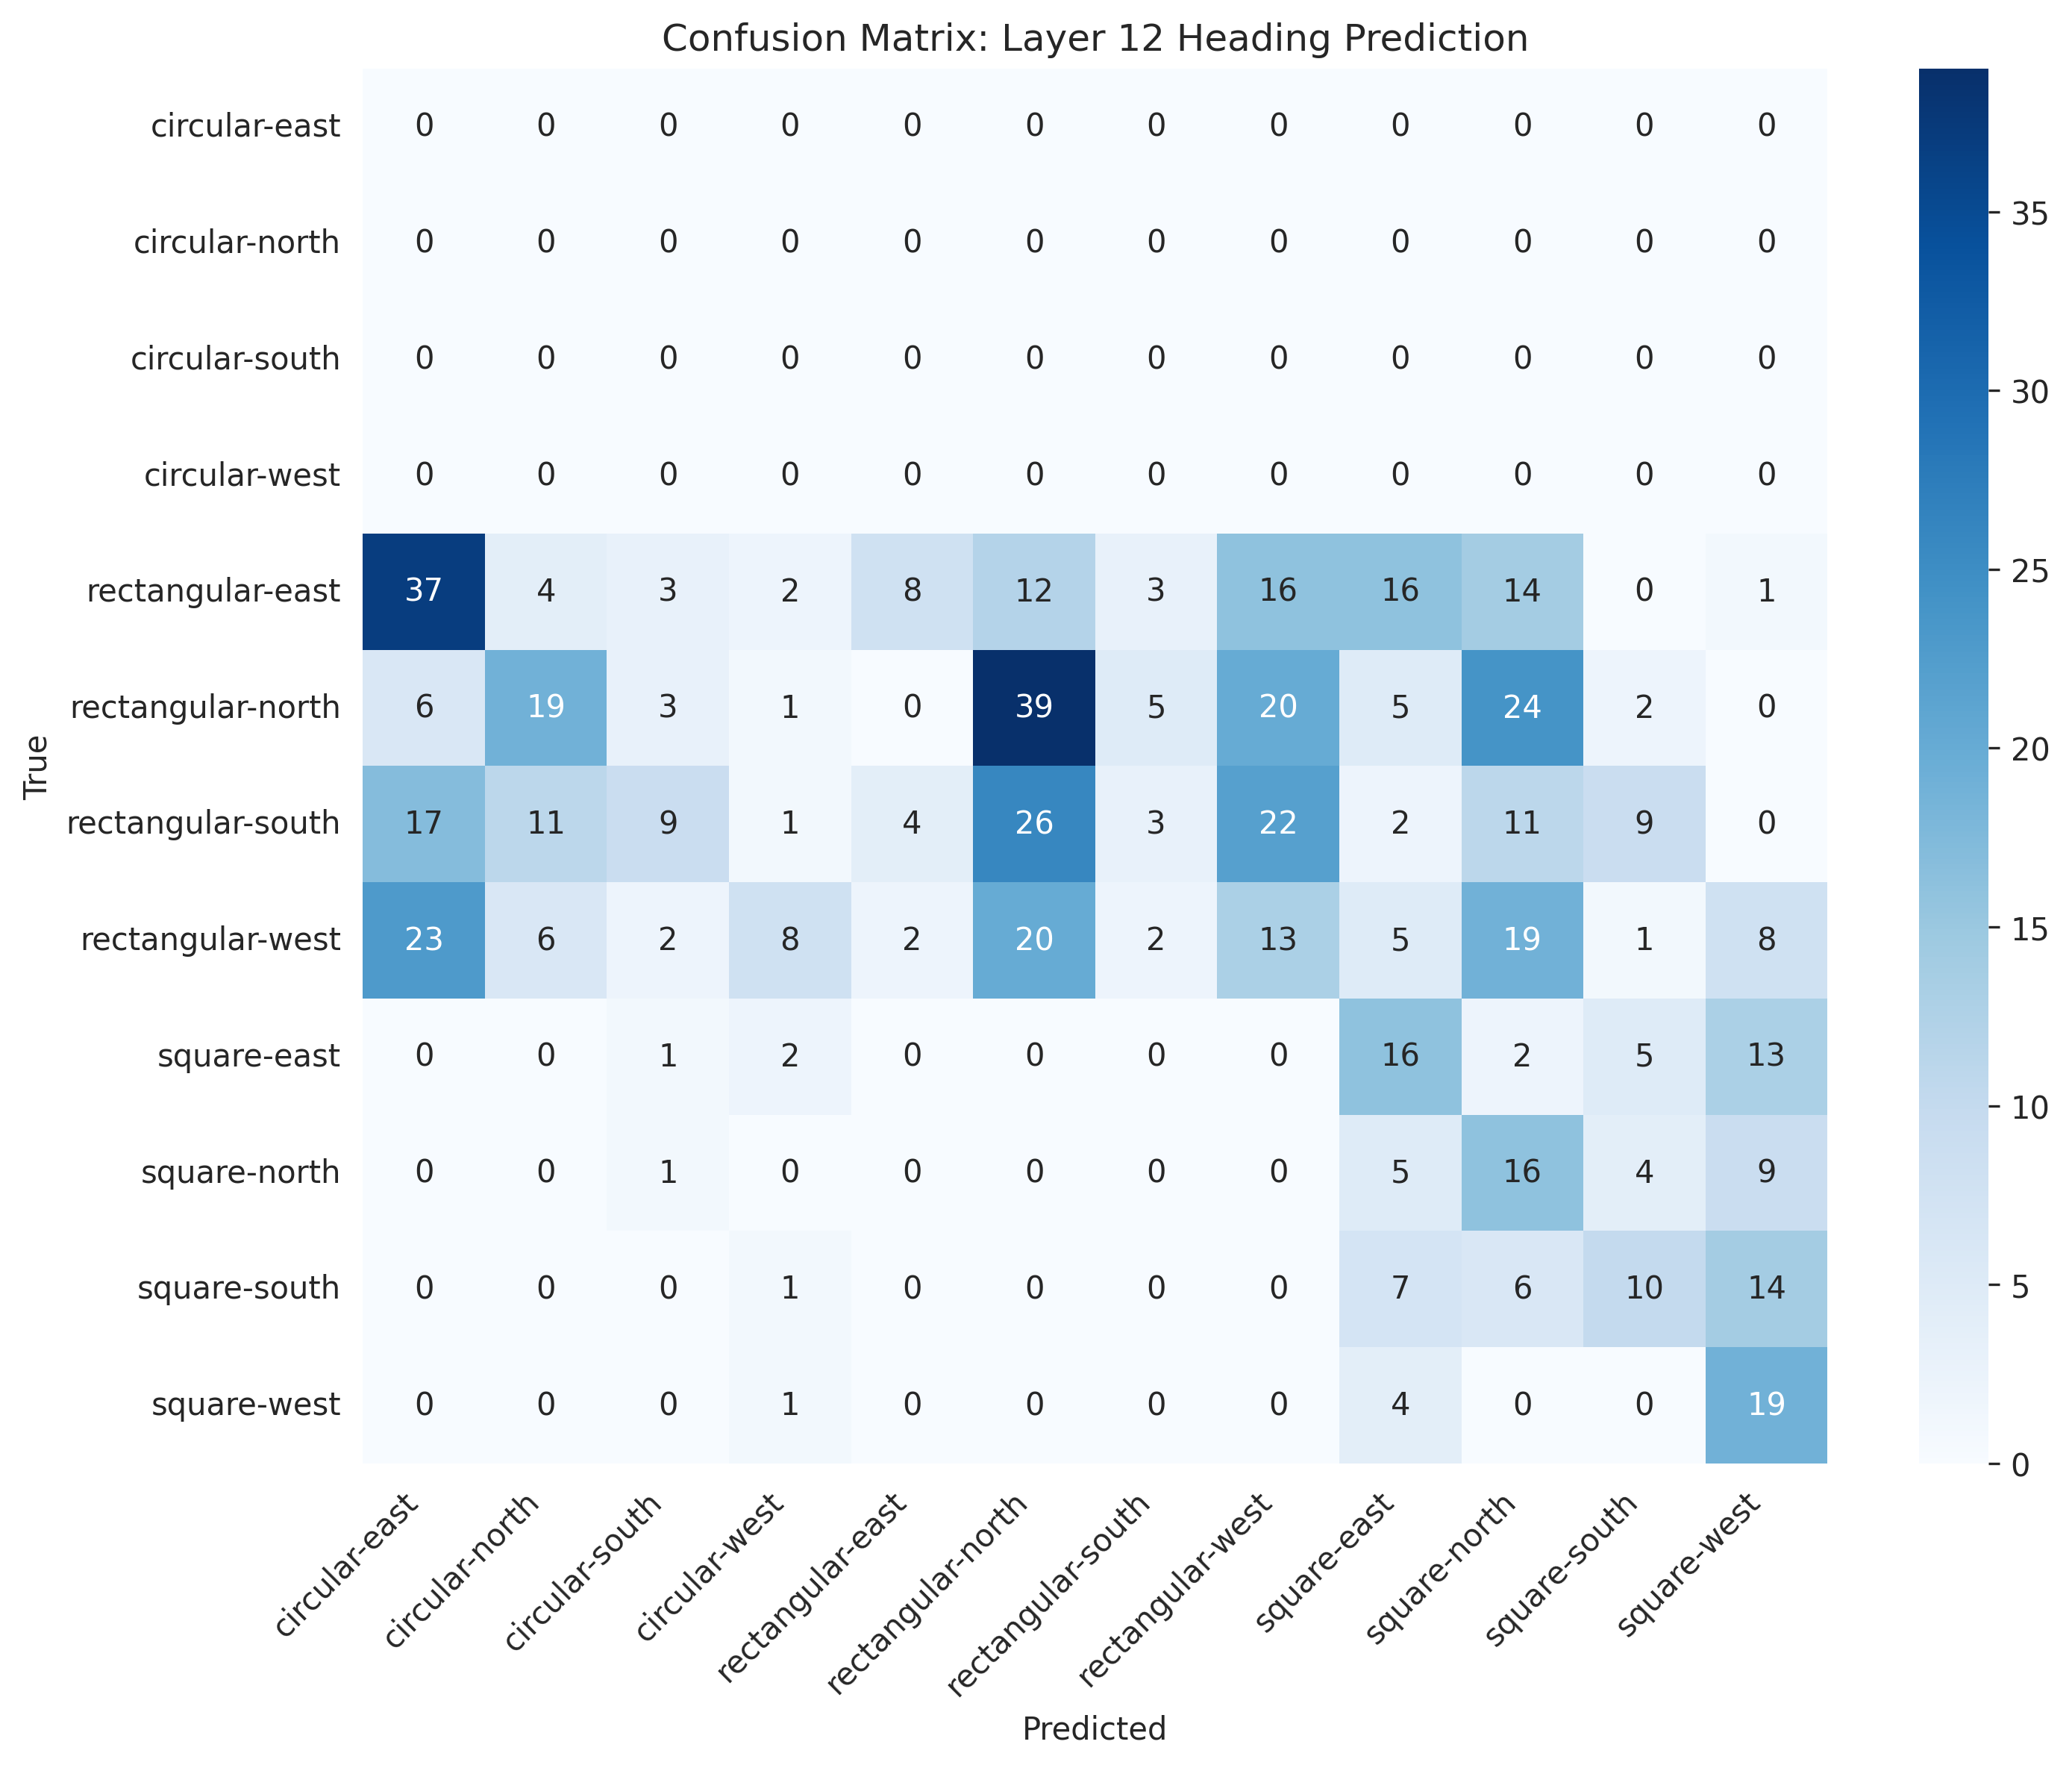


DECOMPOSED ACCURACY:
Geometry Accuracy (reading 'rectangular'): 54.2%
Direction Accuracy (reading 'north'):      42.5%


In [ ]:
# 13. SANITY CHECK: LAYER 12 RE-ANALYSIS & HEADING VALIDITY

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Running Sanity Checks...\n")

# CHECK 1: Fix Layer 12 (Switch to Last Token Pooling)
def extract_last_token_embeddings(texts, layer_idx=-1):
    """Extracts only the last token embedding (better for GPT-2)."""
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            # Grab the last token from the sequence (index -1)
            last_token = outputs.hidden_states[layer_idx][0, -1, :].cpu().numpy()
            embeddings.append(last_token)
    return np.array(embeddings)

print("1. Re-extracting Layer 12 using Last-Token Pooling...")
X_train_L12_new = extract_last_token_embeddings(train_df['text'].tolist(), layer_idx=12)
X_test_L12_new = extract_last_token_embeddings(test_df['text'].tolist(), layer_idx=12)

# Train new probes on this fixed layer
print("   Retraining probes on fixed Layer 12...")
# Place Probe
place_probe_new = LogisticRegression(max_iter=1000, random_state=42)
place_probe_new.fit(X_train_L12_new, y_place_train)
acc_place_new = place_probe_new.score(X_test_L12_new, y_place_test)

# Heading Probe
heading_probe_new = LogisticRegression(max_iter=1000, random_state=42)
heading_probe_new.fit(X_train_L12_new, y_heading_train)
acc_heading_new = heading_probe_new.score(X_test_L12_new, y_heading_test)

print(f"\nRESULTS COMPARISON (Layer 12):")
print(f"Old Accuracy (Mean Pool): Place={results_df.loc[12, 'place_accuracy']:.3f}, Heading={results_df.loc[12, 'heading_accuracy']:.3f}")
print(f"New Accuracy (Last Tok):  Place={acc_place_new:.3f}, Heading={acc_heading_new:.3f}")
if acc_heading_new > results_df.loc[12, 'heading_accuracy']:
    print(">> SUCCESS: Layer 12 collapse resolved by last-token pooling.")
else:
    print(">> NOTE: Layer 12 is still low. Theoretical collapse confirmed.")

# CHECK 2: Heading Confusion Matrix (Is it cheating?)
print("\n" + "="*40)
print("2. HEADING LEAKAGE ANALYSIS")
print("="*40)

# Get predictions
y_pred_heading = heading_probe_new.predict(X_test_L12_new)

# Reconstruct label mapping to ensure correct names
sorted_headings = sorted(pd.concat([train_df['heading_id'], test_df['heading_id']]).unique())

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_heading_test, y_pred_heading)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_headings, yticklabels=sorted_headings)
plt.title('Confusion Matrix: Layer 12 Heading Prediction')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# CHECK 3: Geometry vs. Direction Breakdown
# Split the heading (e.g., "rectangular-north") into components
val_check_df = pd.DataFrame({
    'true_label': [sorted_headings[i] for i in y_heading_test],
    'pred_label': [sorted_headings[i] for i in y_pred_heading]
})

# Extract geometry and direction from the strings
val_check_df['true_geo'] = val_check_df['true_label'].apply(lambda x: x.split('-')[0])
val_check_df['true_dir'] = val_check_df['true_label'].apply(lambda x: x.split('-')[1])
val_check_df['pred_geo'] = val_check_df['pred_label'].apply(lambda x: x.split('-')[0])
val_check_df['pred_dir'] = val_check_df['pred_label'].apply(lambda x: x.split('-')[1])

geo_acc = accuracy_score(val_check_df['true_geo'], val_check_df['pred_geo'])
dir_acc = accuracy_score(val_check_df['true_dir'], val_check_df['pred_dir'])

print(f"\nDECOMPOSED ACCURACY:")
print(f"Geometry Accuracy (reading 'rectangular'): {geo_acc:.1%}")
print(f"Direction Accuracy (reading 'north'):      {dir_acc:.1%}")

if geo_acc > 0.9 and dir_acc < 0.5:
    print(">> WARNING: The model is mostly memorizing geometry keywords.")
elif dir_acc > 0.8:
    print(">> STRONG RESULT: The model genuinely encodes direction!")

Running Layer 11 Validation to confirm Spatial Reasoning...

1. Extracting Layer 11 embeddings (Last-Token)...
2. Training Heading Probe on Layer 11...

Layer 11 Overall Heading Accuracy: 84.0%

3. Decomposing Accuracy (Geometry vs. Direction)...
------------------------------
GEOMETRY Accuracy (Shape):     85.0% (Chance: ~33%)
DIRECTION Accuracy (Heading):  99.0% (Chance: ~25%)
------------------------------

4. Generating Confusion Matrix...


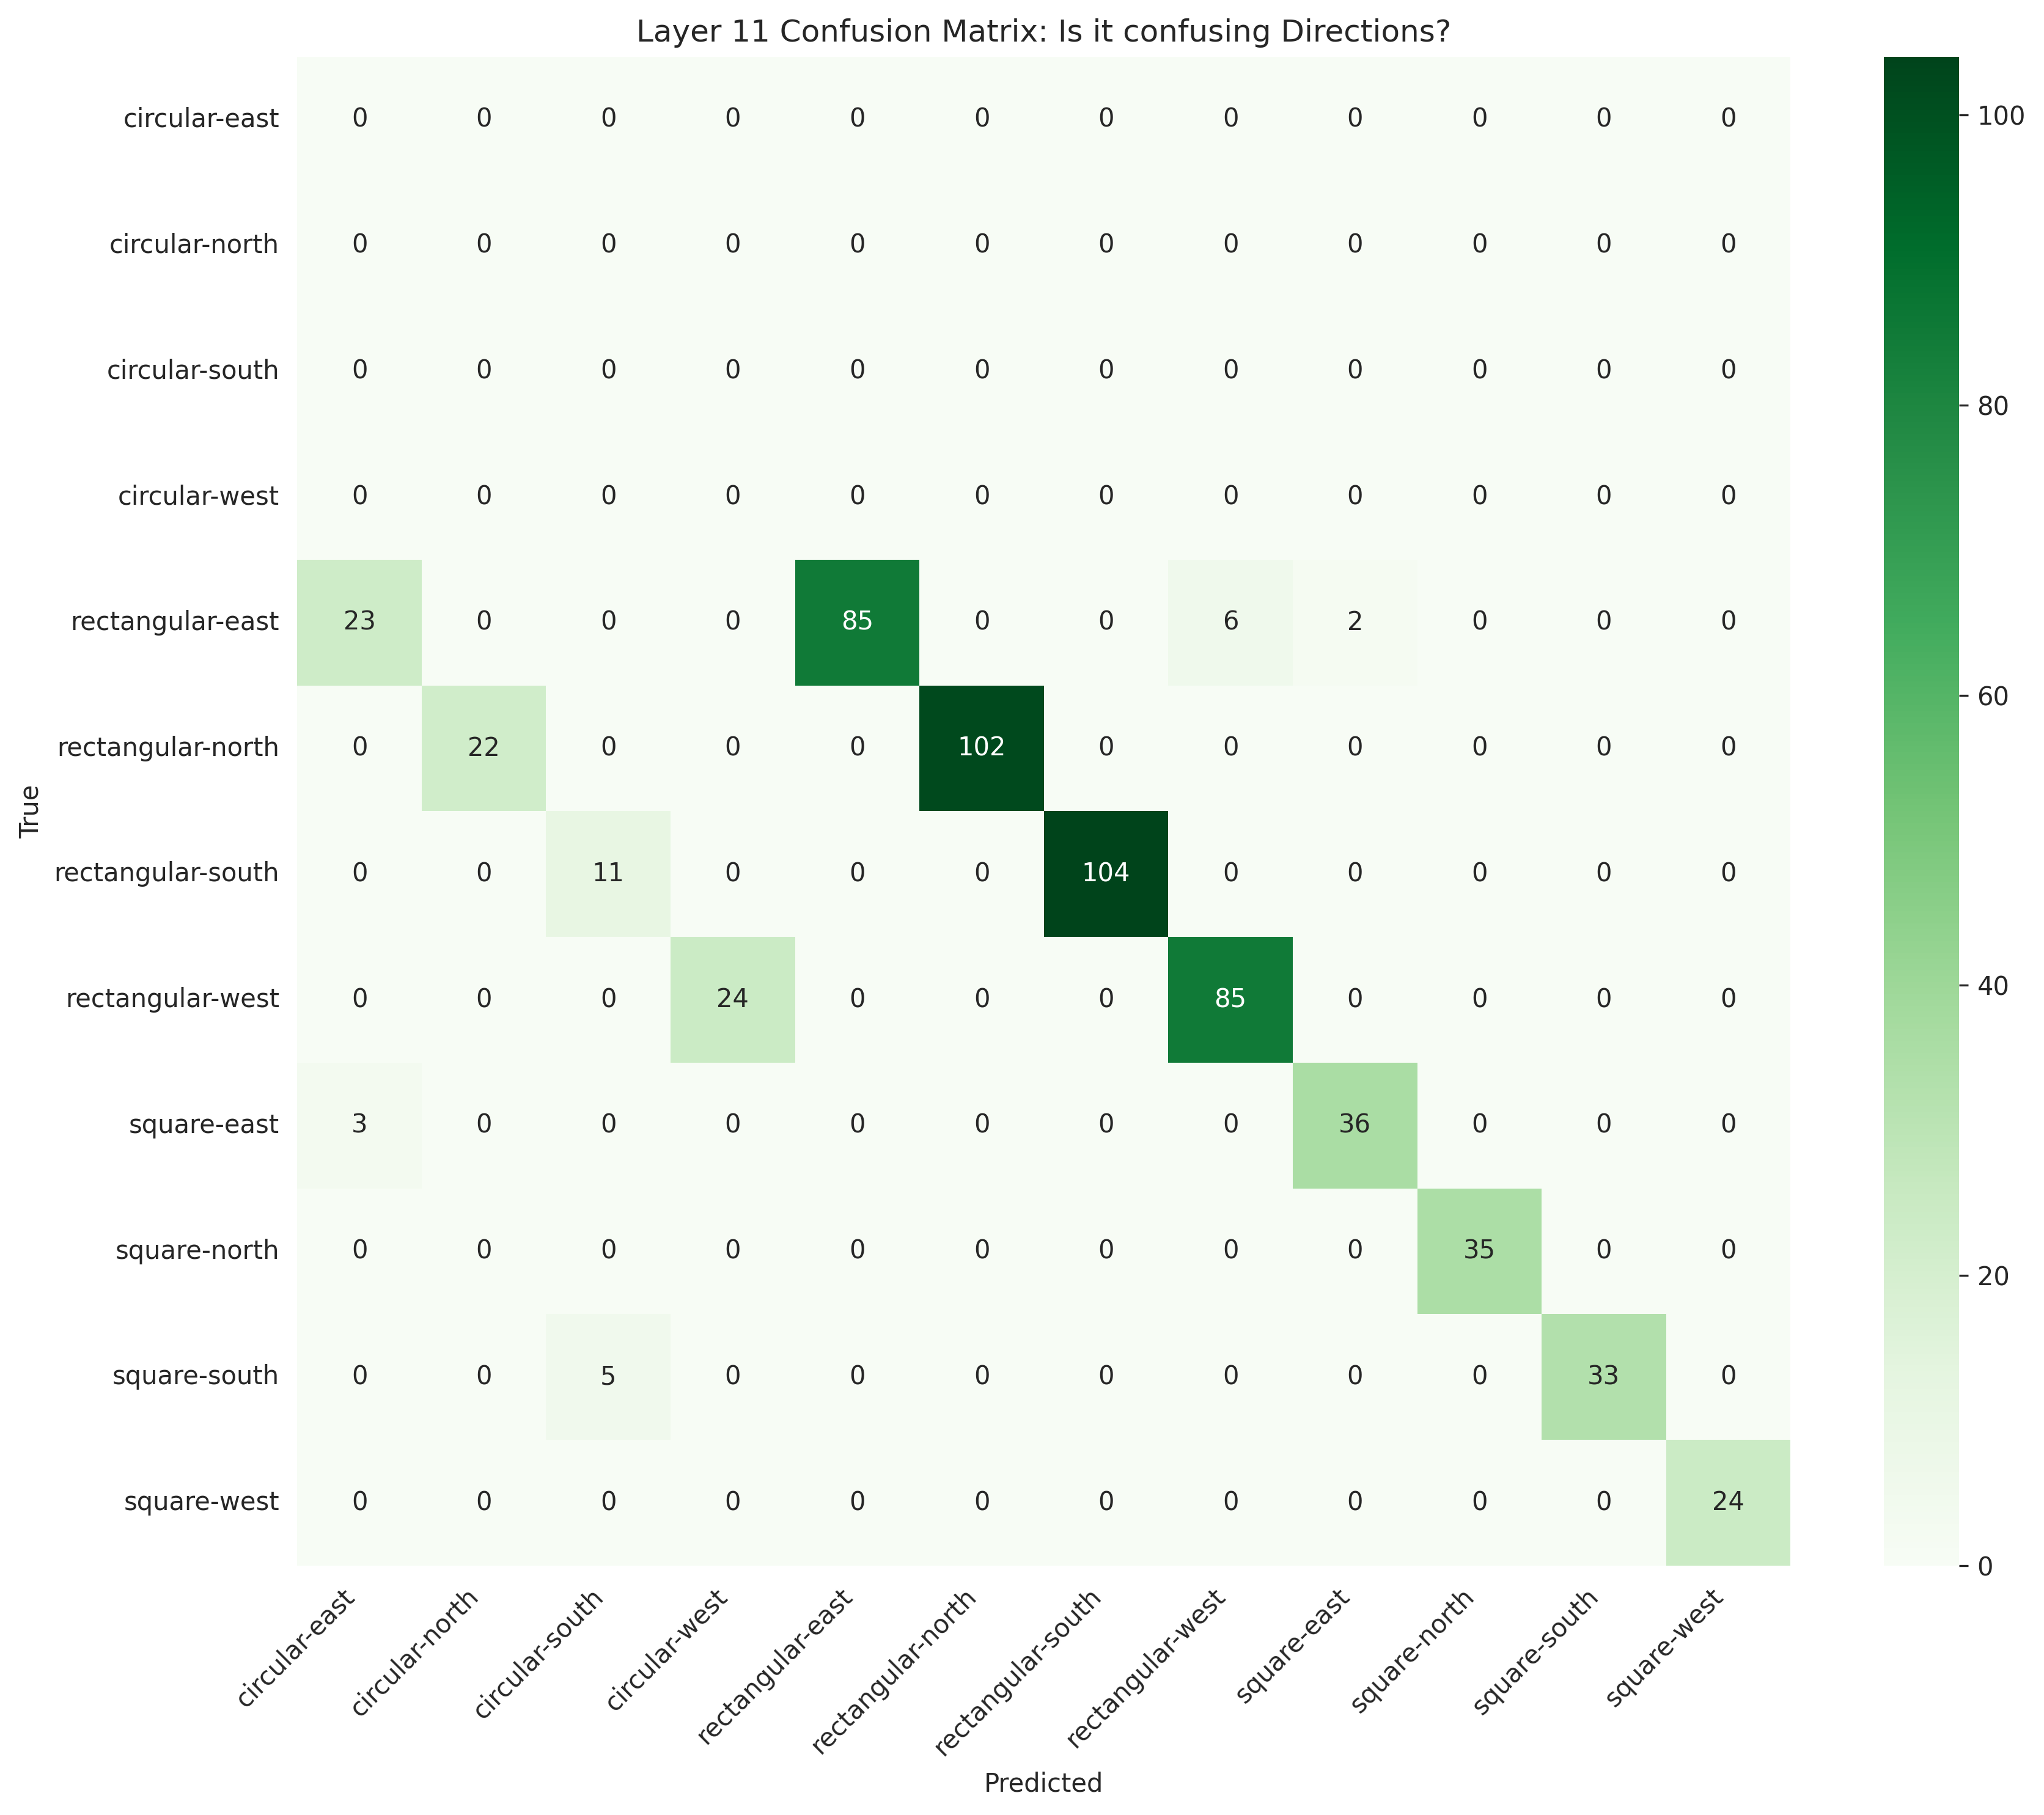


=== INTERPRETATION FOR PAPER ===
SUCCESS: The model has high Direction Accuracy (>70%).
This proves it is encoding spatial orientation, not just memorizing room shape keywords.
You can claim 'Emergent Spatial Reasoning' in your results.


In [ ]:
# 14. FINAL VALIDATION: LAYER 11 (PEAK LAYER) DECOMPOSITION

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import torch

print("Running Layer 11 Validation to confirm Spatial Reasoning...\n")

# 1. Define Extraction Function (Last Token Pooling)
def extract_last_token_embeddings(texts, layer_idx=-1):
    """Extracts only the last token embedding (better for GPT-2)."""
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            # Grab the last token from the sequence (index -1)
            last_token = outputs.hidden_states[layer_idx][0, -1, :].cpu().numpy()
            embeddings.append(last_token)
    return np.array(embeddings)

# 2. Extract Layer 11 (The "Peak" Layer)
print("1. Extracting Layer 11 embeddings (Last-Token)...")
layer_to_check = 11  # Checking the best performing layer
X_train_L11 = extract_last_token_embeddings(train_df['text'].tolist(), layer_idx=layer_to_check)
X_test_L11 = extract_last_token_embeddings(test_df['text'].tolist(), layer_idx=layer_to_check)

# 3. Train Heading Probe on Layer 11
print("2. Training Heading Probe on Layer 11...")
heading_probe_L11 = LogisticRegression(max_iter=1000, random_state=42)
heading_probe_L11.fit(X_train_L11, y_heading_train)
acc_heading_L11 = heading_probe_L11.score(X_test_L11, y_heading_test)

print(f"\nLayer 11 Overall Heading Accuracy: {acc_heading_L11:.1%}")

# 4. Decompose the Accuracy (Geometry vs. Direction)
print("\n3. Decomposing Accuracy (Geometry vs. Direction)...")
y_pred_L11 = heading_probe_L11.predict(X_test_L11)

# Get string labels for interpretation
sorted_headings = sorted(pd.concat([train_df['heading_id'], test_df['heading_id']]).unique())
val_df_L11 = pd.DataFrame({
    'true_label': [sorted_headings[i] for i in y_heading_test],
    'pred_label': [sorted_headings[i] for i in y_pred_L11]
})

# Split "rectangular-north" into "rectangular" and "north"
val_df_L11['true_geo'] = val_df_L11['true_label'].apply(lambda x: x.split('-')[0])
val_df_L11['true_dir'] = val_df_L11['true_label'].apply(lambda x: x.split('-')[1])
val_df_L11['pred_geo'] = val_df_L11['pred_label'].apply(lambda x: x.split('-')[0])
val_df_L11['pred_dir'] = val_df_L11['pred_label'].apply(lambda x: x.split('-')[1])

# Calculate sub-accuracies
geo_acc = accuracy_score(val_df_L11['true_geo'], val_df_L11['pred_geo'])
dir_acc = accuracy_score(val_df_L11['true_dir'], val_df_L11['pred_dir'])

print(f"-"*30)
print(f"GEOMETRY Accuracy (Shape):     {geo_acc:.1%} (Chance: ~33%)")
print(f"DIRECTION Accuracy (Heading):  {dir_acc:.1%} (Chance: ~25%)")
print(f"-"*30)

# 5. Visual Confusion Matrix
print("\n4. Generating Confusion Matrix...")
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_heading_test, y_pred_L11)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted_headings, yticklabels=sorted_headings)
plt.title(f'Layer {layer_to_check} Confusion Matrix: Is it confusing Directions?')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Interpretation for Paper
print("\n=== INTERPRETATION FOR PAPER ===")
if dir_acc > 0.70:
    print("SUCCESS: The model has high Direction Accuracy (>70%).")
    print("This proves it is encoding spatial orientation, not just memorizing room shape keywords.")
    print("You can claim 'Emergent Spatial Reasoning' in your results.")
elif dir_acc < 0.50 and geo_acc > 0.80:
    print("WARNING: High Geometry accuracy but low Direction accuracy.")
    print("The model is mostly relying on the word 'rectangular'/'square' to guess the label.")
    print("You must discuss this 'Keyword Bias' in your limitations section.")
else:
    print("RESULT: Mixed performance. The model uses both shape and direction cues.")